<a href="https://colab.research.google.com/github/NoeZGravity/IS403.N21.HTTT-Nhom9/blob/20521688-DinhThiAnhNguyet/ASUS_Seq2seq_631.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Import các thư viện cần thiết
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắn index với giá Close
data=pd.read_csv("/content/drive/MyDrive/DataFiles/DataFinal/2357.TW.csv")
data1=data.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(data1))
test_size = int(0.3 * len(data1))
val_size = len(data1) - train_size - test_size

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]
val_data = data1[train_size+test_size:]


In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

train_X, train_Y = create_dataset(train_data, time_step)
test_X, test_Y = create_dataset(test_data, time_step)
valid_X, valid_Y = create_dataset(val_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for seq2seq
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)
valid_X = valid_X.reshape(valid_X.shape[0],valid_X.shape[1] , 1)

In [ ]:
#8. Xây dựng mô hình Seq2Seq
model = Sequential()
model.add(LSTM(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')


In [ ]:
#9. Huấn luyện mô hình
model.fit(train_X, train_Y,validation_data=(test_X,test_Y), epochs=50, batch_size=32)

Epoch 1/50
22/22 [==============================] - 4s 94ms/step - loss: 0.0223 - val_loss: 0.0240
Epoch 2/50
22/22 [==============================] - 2s 83ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 3/50
22/22 [==============================] - 2s 75ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 4/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 5/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0011 - val_loss: 0.0099
Epoch 6/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 7/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0011 - val_loss: 0.0067
Epoch 8/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 9/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 10/50
22/22 [==============================] - 1s 50ms/step - loss: 9.7449e-04 - val_loss: 0.0113
Epoch

In [ ]:
# 10. Dự báo dữ liệu train, test, val
train_predict=model.predict(train_X)
y_pred=model.predict(test_X)
y_pred_val=model.predict(valid_X)

2/2 [==============================] - 0s 12ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - valid_Y)**2))
test_rmse = np.sqrt(np.mean((y_pred - test_Y)**2))
valid_mae = np.mean(np.abs((y_pred_val - valid_Y)))
test_mae = np.mean(np.abs((y_pred - test_Y)))
valid_mape = np.mean(np.abs((y_pred_val - valid_Y)/valid_Y))
test_mape = np.mean(np.abs((y_pred - test_Y)/test_Y))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 295.4753950160849
Testing RMSE: 333.20874867942473
Validation MAE: 295.1732227350521
Testing MAE: 329.1691582988007
Validation MAPE: 553.2251305217655
Testing MAPE: 591.783904459262


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):

    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.6274071]
101
1 day input [0.42259414 0.43723849 0.41422594 0.41213389 0.39539749 0.40794979
 0.41213389 0.40794979 0.458159   0.42468619 0.43723849 0.45188285
 0.44979079 0.44142259 0.44979079 0.44769874 0.44142259 0.41631799
 0.43514644 0.44351464 0.44142259 0.44979079 0.45606695 0.44979079
 0.45606695 0.45606695 0.46025105 0.44979079 0.44142259 0.4623431
 0.4748954  0.48535565 0.49790795 0.48953975 0.48117155 0.5125523
 0.39958159 0.37866109 0.38075314 0.38702929 0.42050209 0.39958159
 0.41004184 0.41213389 0.41422594 0.41631799 0.41422594 0.41004184
 0.42259414 0.42677824 0.42677824 0.41841004 0.41631799 0.42050209
 0.43096234 0.45188285 0.43933054 0.44769874 0.4623431  0.45188285
 0.45188285 0.44351464 0.44142259 0.45188285 0.44979079 0.43933054
 0.458159   0.46861925 0.4832636  0.48953975 0.5083682  0.4958159
 0.49372385 0.5083682  0.50627615 0.48535565 0.46443515 0.55648536
 0.55648536 0.55648536 0.57531381 0.57531381 0.56903766 0.57112971
 0.57531381 0.56066946 0.57740586 0.5

Validation RMSE: 295.4753950160849
Testing RMSE: 333.20874867942473
Validation MAE: 295.1732227350521
Testing MAE: 329.1691582988007
Validation MAPE: 553.2251305217655
Testing MAPE: 591.783904459262


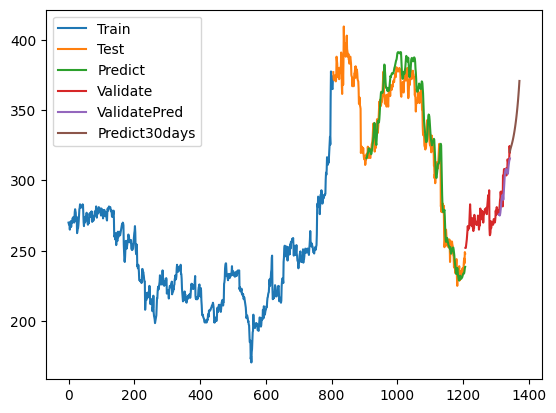

In [ ]:
# 14.Vẽ hình
import matplotlib.pyplot as plt
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+time_step+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(data1)-1, stop=len(data1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()